In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias.html

In [2]:
filename = 'covid19-es-and.csv'
fecha = '29/05/2021'
id_noticia = '260527'
url = 'https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias/detalle/' + id_noticia + '.html'
dias_grafico = 180

In [3]:
def DrawMediaFlotante (dfData, provincia, dias):   
    data = dfData.loc[provincia].diff().tail(dias).copy()
    data['Media Positivo 7 dias'] = data['PCR Positivo'].rolling(window=7).mean()
    data['Media Positivo 14 dias'] = data['PCR Positivo'].rolling(window=14).mean()
    titulo = 'Nuevos casos en los últimos ' + str(dias) + ' días en ' + provincia
    # print(titulo + '. (Nuevos positivos e ingresos hospitalarios)')
    data[['Hospitalización', 'PCR Positivo', 'Media Positivo 7 dias', 'Media Positivo 14 dias']].plot(
        kind='line', grid=True, figsize=(15,5), title=titulo)
    plt.xticks(
        rotation=45,    
        horizontalalignment='right',
        fontweight='light',
    )
    plt.show()
    

In [4]:
# FIX SSL: CERTIFICATE_VERIFY_FAILED with Python3
# https://stackoverflow.com/a/49174340
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [6]:
# Load
tables = pd.read_html(url, header=0, thousands='.')
assert len(tables) > 0
dfL = tables[0]

In [7]:
# Prepare
dfL.columns = ['Provincia', 'PCR Positivo',	'Hospitalización', 'UCI', 'Fallecimientos',	'Curados']
dfL['Fecha'] = fecha

for col in ['PCR Positivo',	'Hospitalización', 'UCI', 'Fallecimientos',	'Curados']:
    dfL[col] = dfL[col].str.split(' ').str[0].str.replace('*', '')

dfL

,Provincia,PCR Positivo,Hospitalización,UCI,Fallecimientos,Curados,Fecha
0,Almería,54.436,3.839,658,830,52.923,29/05/2021
1,Cádiz,81.168,5.662,642,1.483,77.438,29/05/2021
2,Córdoba,51.991,4.482,558,955,49.679,29/05/2021
3,Granada,87.135,8.000,1.029,1.756,82.269,29/05/2021
4,Huelva,30.781,2.222,158,378,28.370,29/05/2021
5,Jaén,49.087,4.578,432,983,46.377,29/05/2021
6,Málaga,99.464,8.053,767,1.645,95.820,29/05/2021
7,Sevilla,127.913,10.499,1.047,1.989,118.978,29/05/2021
8,Total,581.975,47.335,5.291,10.019,551.854,29/05/2021


In [8]:
data = pd.melt(dfL, id_vars=['Provincia', 'Fecha'])
# data.sample(5)

In [9]:
# Save to csv
data.to_csv(filename, encoding='utf-8', header=False, mode='+a', index=False)

In [10]:
# Load full csv
dfL = pd.read_csv(filename, thousands='.', parse_dates=['Fecha'], dayfirst=True)
# dfL.tail()

In [11]:
# Guardar el último día
last_fecha = dfL['Fecha'].max()

In [12]:
# Organizar en forma de tabla
df = pd.pivot_table(dfL, values='value', index=['Provincia', 'Fecha'], columns='variable')
df.sort_index(inplace=True)

In [13]:
# Variaciones con respecto al día anterior
dfV = df.groupby(level='Provincia').diff()
# dfV.tail()

In [14]:
# Para seleccionar todas las filas de una o varias fechas hay que usar un trick ya que : no se puede usar en este caso
dfG = dfV.loc[(slice(None), [last_fecha]), :]
dfG

,variable,Curados,Fallecimientos,Hospitalización,PCR Positivo,UCI
Provincia,Fecha,,,,,
Almería,2021-05-29,70.0,1.0,2.0,50.0,1.0
Cádiz,2021-05-29,161.0,0.0,3.0,211.0,1.0
Córdoba,2021-05-29,158.0,0.0,5.0,131.0,1.0
Granada,2021-05-29,487.0,2.0,17.0,181.0,7.0
Huelva,2021-05-29,129.0,1.0,2.0,128.0,0.0
Jaén,2021-05-29,182.0,0.0,16.0,175.0,5.0
Málaga,2021-05-29,79.0,1.0,8.0,232.0,3.0
Sevilla,2021-05-29,537.0,0.0,12.0,487.0,0.0
Total,2021-05-29,1803.0,5.0,65.0,1595.0,18.0


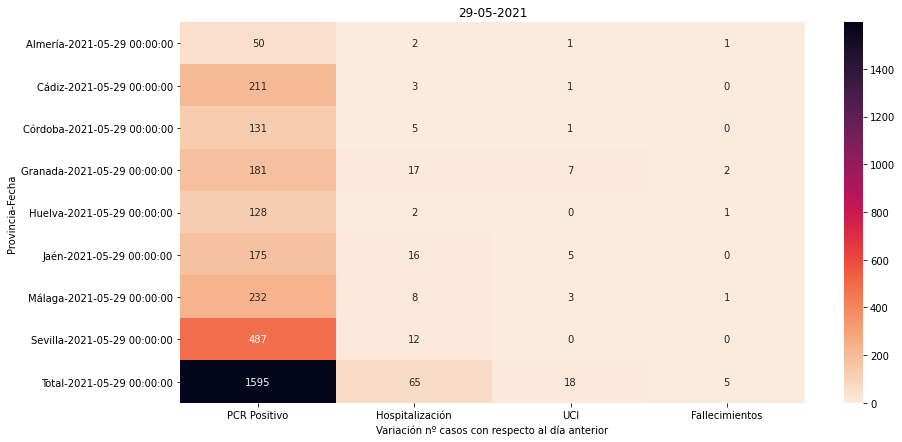

In [15]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title(last_fecha.strftime('%d-%m-%Y'))

# Invertir los colores
cmap = sns.cm.rocket_r

# Heatmap 
sns.heatmap(data=dfG[['PCR Positivo', 'Hospitalización', 'UCI', 'Fallecimientos']], annot=True, cmap=cmap,fmt='g')

# Add label for horizontal axis
plt.xlabel('Variación nº casos con respecto al día anterior')
plt.show()

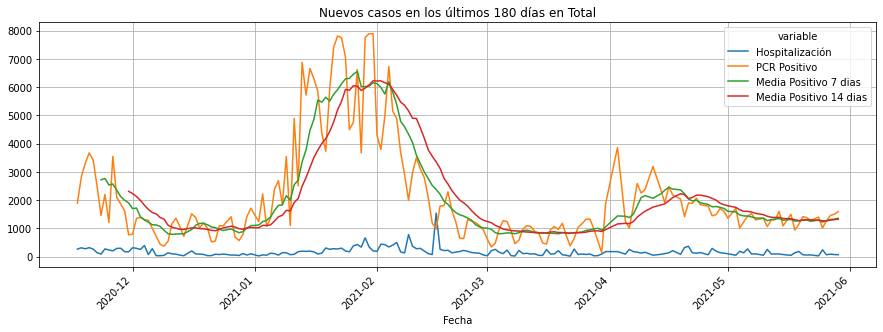

In [16]:
DrawMediaFlotante(df, 'Total', dias_grafico)

In [17]:
# Fecha de último ingreso en hospital
data = df[['Hospitalización']].diff()
data = data[data['Hospitalización'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values('dias', ascending=False)

variable,Fecha,Hospitalización,dias
Provincia,,,
Total,2021-05-29,65.0,0 days
Sevilla,2021-05-29,12.0,0 days
Málaga,2021-05-29,8.0,0 days
Jaén,2021-05-29,16.0,0 days
Huelva,2021-05-29,2.0,0 days
Granada,2021-05-29,17.0,0 days
Córdoba,2021-05-29,5.0,0 days
Cádiz,2021-05-29,3.0,0 days
Almería,2021-05-29,2.0,0 days


In [18]:
# Positivos por cada Hospitalización
dfG['PCR Positivo']/dfG['Hospitalización']

Provincia  Fecha     
Almería    2021-05-29    25.000000
Cádiz      2021-05-29    70.333333
Córdoba    2021-05-29    26.200000
Granada    2021-05-29    10.647059
Huelva     2021-05-29    64.000000
Jaén       2021-05-29    10.937500
Málaga     2021-05-29    29.000000
Sevilla    2021-05-29    40.583333
Total      2021-05-29    24.538462
dtype: float64

In [19]:
# Fecha de último ingreso en UCI
data = df[['UCI']].diff()
data = data[data['UCI'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values('dias', ascending=False)

variable,Fecha,UCI,dias
Provincia,,,
Huelva,2021-05-25,1.0,4 days
Sevilla,2021-05-28,1.0,1 days
Total,2021-05-29,18.0,0 days
Málaga,2021-05-29,3.0,0 days
Jaén,2021-05-29,5.0,0 days
Granada,2021-05-29,7.0,0 days
Córdoba,2021-05-29,1.0,0 days
Cádiz,2021-05-29,1.0,0 days
Almería,2021-05-29,1.0,0 days


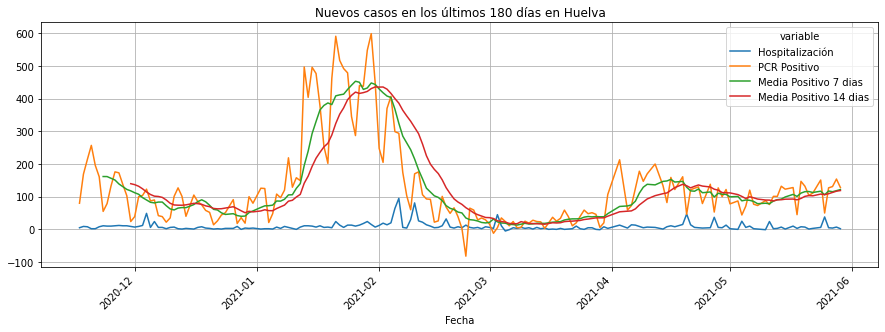

In [20]:
DrawMediaFlotante(df, 'Huelva', dias_grafico)

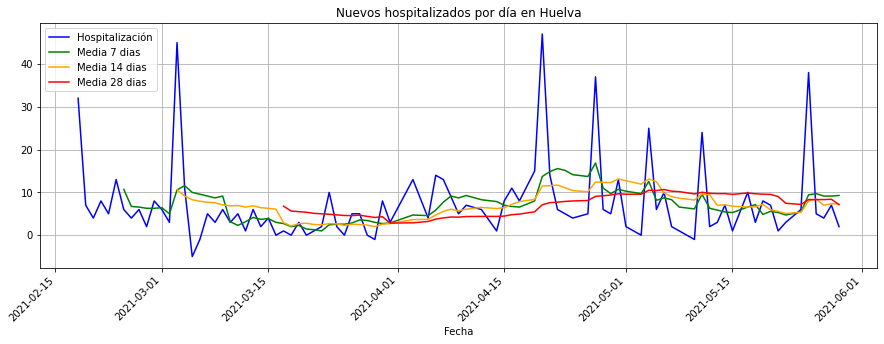

In [21]:
data = pd.DataFrame(dfV.loc['Huelva']['Hospitalización'].tail(90).copy())
data.columns = ['Hospitalización']
data['Media 7 dias'] = data['Hospitalización'].rolling(window=7).mean()
data['Media 14 dias'] = data['Hospitalización'].rolling(window=14).mean()
data['Media 28 dias'] = data['Hospitalización'].rolling(window=28).mean()
data.plot(title='Nuevos hospitalizados por día en Huelva', figsize=(15,5), grid=True, color = ['blue', 'green', 'orange', 'red'])
plt.xticks(
    rotation=45,    
    horizontalalignment='right',
    fontweight='light',
)
plt.show()

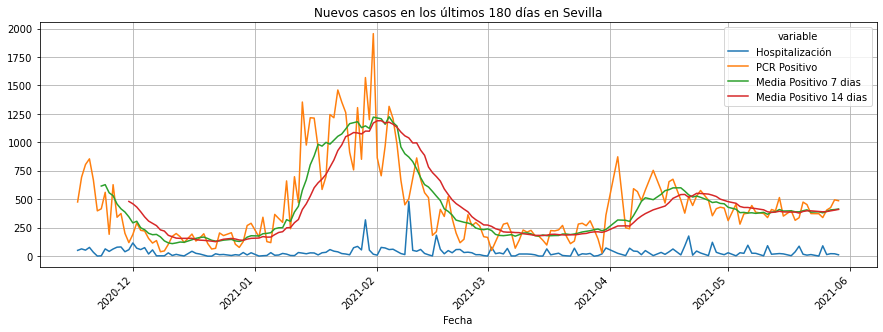

In [22]:
DrawMediaFlotante(df, 'Sevilla', dias_grafico)

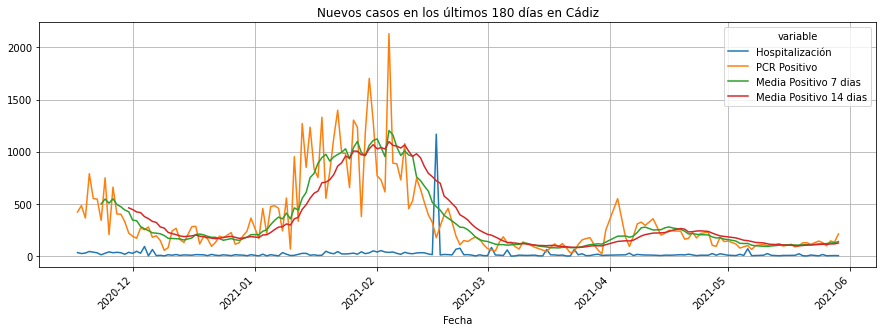

In [23]:
DrawMediaFlotante(df, 'Cádiz', dias_grafico)

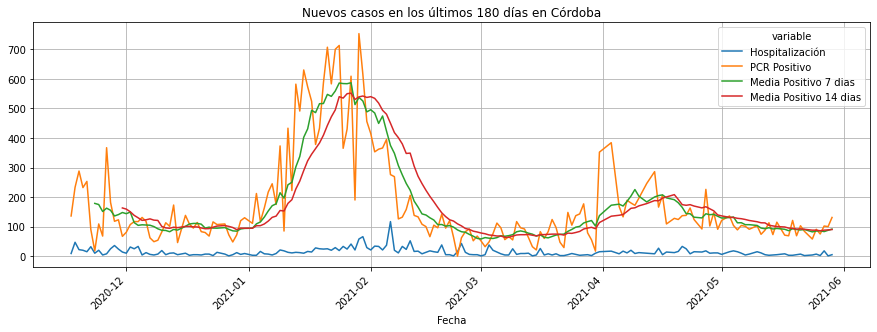

In [24]:
DrawMediaFlotante(df, 'Córdoba', dias_grafico)

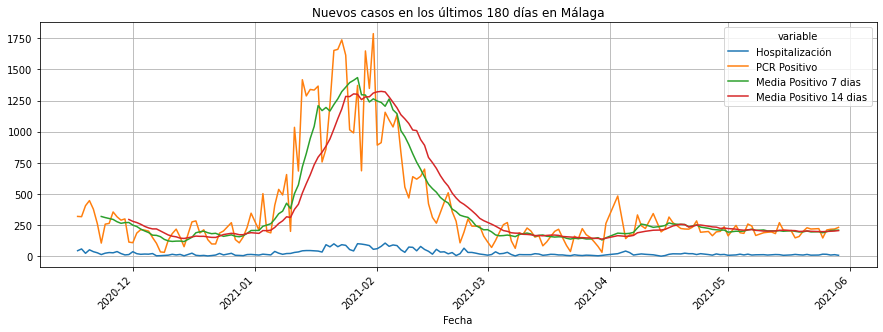

In [25]:
DrawMediaFlotante(df, 'Málaga', dias_grafico)

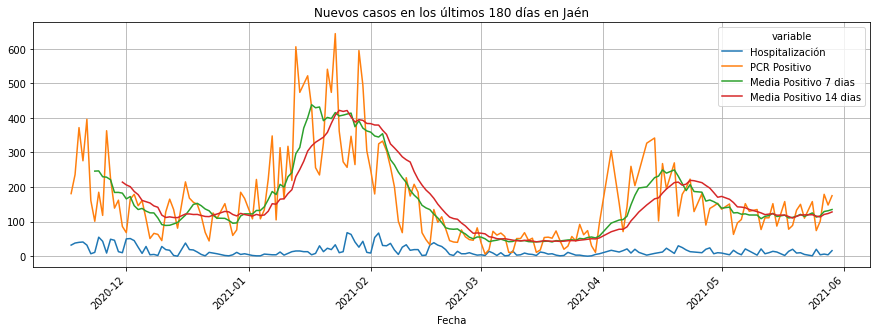

In [26]:
DrawMediaFlotante(df, 'Jaén', dias_grafico)

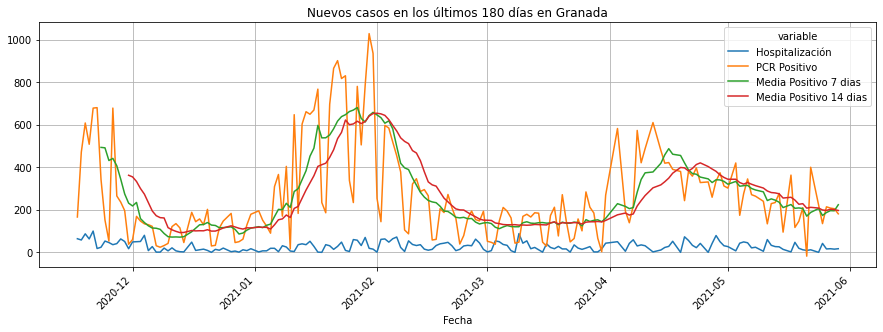

In [27]:
DrawMediaFlotante(df, 'Granada', dias_grafico)

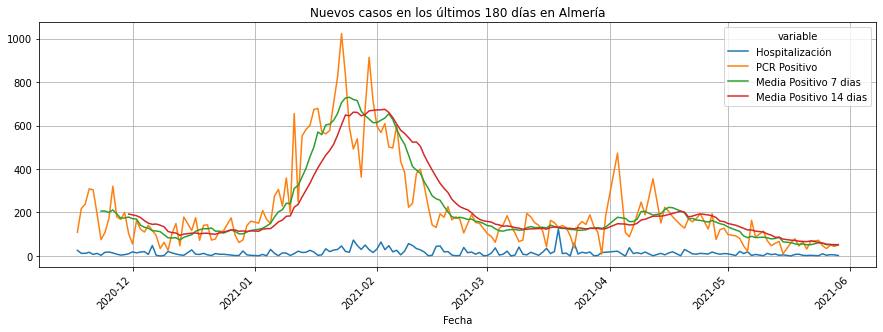

In [28]:
DrawMediaFlotante(df, 'Almería', dias_grafico)